# I) Summary

- The paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf) introduces a new principle method to scale up ConvNets.
- To get a better accuracy, CNN needs to have a careful balance between depth width and resolution. However, process of scaling up ConvNets has never been understood.

- Most common way was to scale up ConvNets by their depth or width.
- Another less common way was to scale up models by image resolution. So far, we only scale one dimension at the time.

    - **Depth**:
            Deeper ConvNets capture more complex features and generalize well.
            However, more difficult to train due to vanishing gradient. Although
            techniques such as "skip connections" and "batch normalization" are
            alleviating the training problem, the accuracy gain diminishes for
            very deep network.

    - **Width**: 
            Wider networks tend to capture more fined-grained features and are easier
            to train. However, accuracy for such network tends to quickly saturate.

    - **Resolution**:
            With higher resolution input images, ConvNets can potentially
            capture more fine-grained patterns. However, for very high
            resolutions, the accuracy gains disminishes.


![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/1.png)

---

- We can then think about scaling multiple dimension at one time. It is possible to scale two or three dimensions arbitrarily, requiring manual  tuning which often yields to sub-optimal accuracy and efficiency.

- In this paper, they are trying to address the following issue:

    **"Is there a principled method to scale up ConvNets that can achieve better accuracy and efficiency ?"**


- Their empirical study shows that it is **critical to balance all dimensions of network** (width/depth/resolution) at the same time.

- Such balance can be achieved by **scaling** each of them by a **constant ratio**.

- This method is called **"compound scaling method"**, which consists of **uniformly scales the network width, depth and resolution with a set of fixed scaling coefficients**.

- The intuition comes from the following fact: 

    - If the input image is bigger (resolution), then there is more complex-features and fine-grained patterns. To capture more complex-feature, the network needs bigger receptive field which is achieved by adding more layers (depth). To capture more fine-grained patterns, the network needs more channels.
    
    - The following validates the intuition.
![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/2.png)

---

- The "compound scaling method" uses a compound coefficient $\phi$ to uniformly scales network width, depth and resolution in a principled way:

![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/3.png)

where $\alpha$, $\beta$, $\gamma$ are constants that can be determined by a small grid search.

- In this paper, the constraint $\alpha$ · $\beta^2$ · $\gamma^2$  ≈ 2 such that for any new $\phi$, the total FLOPS will approximately 3 increase by $2^\phi$. 

- To use this method, a baseline model is needed which is, here, called "EfficientNet B0". It was design by a neural architecture search (NAS)

- We then apply the compound scaling method to scale it up with 2 steps:

![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/4.png)

---
Here is EfficientNet-B0 architecture:

![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/5.png)

---

![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/6.png)

---

![](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/efficientnet/7.png)

# Implementation

**DISCLAIMER**: 

- I didn't add **momentum** to BatchNormalization.

In [2]:
from utils import *
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, DepthwiseConv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Reshape, multiply, add, Activation

In [3]:
def EfficientNet_B0(channels,
                    expansion_coefs,
                    repeats,
                    strides,
                    kernel_sizes,
                    d_coef,
                    w_coef,
                    r_coef,
                    dropout_rate,
                    include_top,
                    se_ratio = 0.25,
                    classes=1000):
   
    inputs = Input(shape=(224, 224, 3))
    
    stage1 = ConvBlock(inputs,
                       filters=32,
                       kernel_size=3,
                       stride=2)
    
    stage2 = MBConvBlock(stage1, 
                         scaled_channels(channels[0], w_coef),
                         scaled_channels(channels[1], w_coef),
                         kernel_sizes[0],
                         expansion_coefs[0],
                         se_ratio,
                         strides[0],
                         scaled_repeats(repeats[0], d_coef),
                         dropout_rate=dropout_rate)
    
    stage3 = MBConvBlock(stage2, 
                         scaled_channels(channels[1], w_coef),
                         scaled_channels(channels[2], w_coef),
                         kernel_sizes[1],
                         expansion_coefs[1],
                         se_ratio,
                         strides[1],
                         scaled_repeats(repeats[1], d_coef),
                         dropout_rate=dropout_rate)
    
    stage4 = MBConvBlock(stage3, 
                         scaled_channels(channels[2], w_coef),
                         scaled_channels(channels[3], w_coef),
                         kernel_sizes[2],
                         expansion_coefs[2],
                         se_ratio,
                         strides[2],
                         scaled_repeats(repeats[2], d_coef),
                         dropout_rate=dropout_rate)
    
    stage5 = MBConvBlock(stage4, 
                         scaled_channels(channels[3], w_coef),
                         scaled_channels(channels[4], w_coef),
                         kernel_sizes[3],
                         expansion_coefs[3],
                         se_ratio,
                         strides[3],
                         scaled_repeats(repeats[3], d_coef),
                         dropout_rate=dropout_rate)

    stage6 = MBConvBlock(stage5, 
                         scaled_channels(channels[4], w_coef),
                         scaled_channels(channels[5], w_coef),
                         kernel_sizes[4],
                         expansion_coefs[4],
                         se_ratio,
                         strides[4],
                         scaled_repeats(repeats[4], d_coef),
                         dropout_rate=dropout_rate)
    
    stage7 = MBConvBlock(stage6, 
                         scaled_channels(channels[5], w_coef),
                         scaled_channels(channels[6], w_coef),
                         kernel_sizes[5],
                         expansion_coefs[5],
                         se_ratio,
                         strides[5],
                         scaled_repeats(repeats[5], d_coef),
                         dropout_rate=dropout_rate)
    
    stage8 = MBConvBlock(stage7, 
                         scaled_channels(channels[6], w_coef),
                         scaled_channels(channels[7], w_coef),
                         kernel_sizes[6],
                         expansion_coefs[6],
                         se_ratio,
                         strides[6],
                         scaled_repeats(repeats[6], d_coef),
                         dropout_rate=dropout_rate)
       
    stage9 = ConvBlock(stage8,
                       filters=scaled_channels(channels[8], w_coef),
                       kernel_size=1,
                       padding='same')
    
    if include_top:
        stage9 = GlobalAveragePooling2D()(stage9)

        if dropout_rate > 0:
            stage9 = Dropout(dropout_rate)(stage9)

        stage9 = Dense(classes, 
                       activation='softmax',
                       kernel_initializer=DENSE_KERNEL_INITIALIZER)(stage9)

    model = Model(inputs, stage9)

    return model

In [4]:
include_top = True
channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
expansion_coefs = [1, 6, 6, 6, 6, 6, 6]
repeats = [1, 2, 2, 3, 3, 4, 1]
strides = [1, 2, 2, 2, 1, 2, 1]
kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
d_coef, w_coef, r_coef, dropout_rate = efficientnet_params('efficientnet-b0')   

conv_base = EfficientNet_B0(channels,
                            expansion_coefs,
                            repeats,
                            strides,
                            kernel_sizes,
                            d_coef,
                            w_coef,
                            r_coef,
                            dropout_rate,
                            include_top=include_top)
conv_base.summary()
if include_top:
    conv_base.load_weights('data/pretrained_model_imagenet_top.h5')
else:
    conv_base.load_weights('data/pretrained_model_imagenet_notop.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

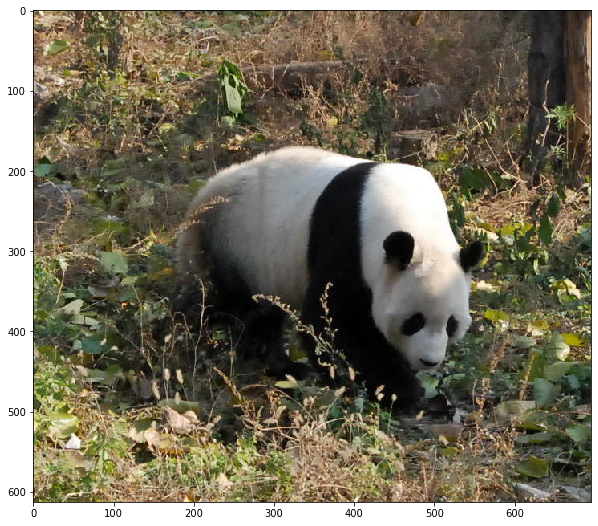

In [5]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# test image
image = imread('img/panda.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [6]:
# ImageNet mean and std.
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# preprocess input
image_size = conv_base.input_shape[1]
x = center_crop_and_resize(image, image_size=image_size)
x /= 255
x = (x - mean) / std
x = np.expand_dims(x, 0)

In [7]:
y = conv_base.predict(x)
decode_predictions(y)

[[('n02510455', 'giant_panda', 0.7587868),
  ('n02134084', 'ice_bear', 0.008354766),
  ('n02132136', 'brown_bear', 0.0072072325),
  ('n02509815', 'lesser_panda', 0.0041302308),
  ('n02120079', 'Arctic_fox', 0.004021083)]]

# Transfer Learning

- [x] Transfer Learning on CIFAR-10
    - Check /save_weight/cifar10/cifar10-log.txt

## CIFAR-10

In [22]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import UpSampling2D, GlobalMaxPooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

In [23]:
# Load Cifar-10.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shuffle train set.
X_train = shuffle(X_train, random_state=42)
y_train = shuffle(y_train, random_state=42)

# Split train set.
X_val = X_train[40000:, ...]
X_train = X_train[:40000, ...]
y_val = y_train[40000:, ...]
y_train = y_train[:40000, ...]

# One-hot encoding.
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=32)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow(X_val,
                                 y_val,
                                 batch_size=32)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow(X_test,
                                   y_test,
                                   batch_size=32)

### Model

In [ ]:
include_top = False  

conv_base = EfficientNet_B0(channels,
                            expansion_coefs,
                            repeats,
                            strides,
                            kernel_sizes,
                            d_coef,
                            w_coef,
                            r_coef,
                            dropout_rate,
                            include_top=include_top)
conv_base.summary()
if include_top:
    conv_base.load_weights('data/pretrained_model_imagenet_top.h5')
else:
    conv_base.load_weights('data/pretrained_model_imagenet_notop.h5')

model1 = models.Sequential()
model1.add(UpSampling2D(size=(7,7), input_shape=(32,32,3)))
model1.add(conv_base)
model1.add(GlobalMaxPooling2D(name="gap"))
model1.add(Dropout(0.2, name="dropout_out"))
model1.add(Dense(10, activation='softmax', name="fc_out"))

### Training model

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

filepath = "save_weight/cifar10/weights-improvement-{epoch:02d}-{acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model1.fit_generator(train_generator,
                    steps_per_epoch=len(X_train)//32,
                    validation_data=val_generator,
                    validation_steps=len(X_val)//32,
                    epochs=20,
                    callbacks=callbacks_list,
                    workers=4,
                    verbose=1)

### Evaluate model

In [ ]:
model1.evaluate_generator(test_generator, verbose=1)

## CINIC-10

- [x] Transfer Learning on CINIC-10
    - Check /save_weight/cinic10/cinic10-log.txt

<ins><b>SOTA</b></ins>: ResNeXt29_2x64d / 9.2M parameters / acc = 91.45.

In [27]:
import cinic10

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = cinic10.loadData("data/", oneHot=True)

In [ ]:
MEAN_RGB = [0.47889522, 0.47227842, 0.43047404]
STDDEV_RGB = [0.24205776, 0.23828046, 0.25874835]

def preprocess_input(x):
    x = x - np.array(MEAN_RGB)
    x = x / np.array(STDDEV_RGB)

    return x

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=32)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow(X_val,
                                 y_val,
                                 batch_size=32)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow(X_test,
                                   y_test,
                                   batch_size=32)

### Model

In [ ]:
include_top = False
channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
expansion_coefs = [1, 6, 6, 6, 6, 6, 6]
repeats = [1, 2, 2, 3, 3, 4, 1]
strides = [1, 2, 2, 2, 1, 2, 1]
kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
d_coef, w_coef, r_coef, dropout_rate = efficientnet_params('efficientnet-b0')   


conv_base2 = EfficientNet_B0(channels,
                             expansion_coefs,
                             repeats,
                             strides,
                             kernel_sizes,
                             d_coef,
                             w_coef,
                             r_coef,
                             dropout_rate,
                             include_top=include_top)


model2 = models.Sequential()
model2.add(UpSampling2D(size=(7,7), input_shape=(32,32,3)))
model2.add(conv_base2)
model2.add(GlobalMaxPooling2D(name="gap"))
model2.add(Dropout(0.2, name="dropout_out"))
model2.add(Dense(10, activation='softmax', name="fc_out"))

### Training model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['acc'])

filepath = "save_weight/cinic10/weights-improvement-{epoch:02d}-{acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit_generator(train_generator,
                    steps_per_epoch=len(X_train)//32,
                    validation_data=val_generator,
                    validation_steps=len(X_val)//32,
                    epochs=20,
                    callbacks=callbacks_list,
                    workers=4,
                    verbose=1)

### Evaluate model

In [ ]:
model.evaluate_generator(test_generator, verbose=1)